<a href="https://colab.research.google.com/github/HernanArand/Agrupamiento/blob/main/Examen_de_certificacion_Intento_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1: Análisis No Supervisado

1. Carga y Exploración de Datos:

In [ ]:
from google.colab import files

# Subir el archivo manualmente
uploaded = files.upload()

# Verificar si el archivo está presente
if "seg_train.zip" in uploaded:
    print("✅ Archivo cargado correctamente.")
else:
    print("❌ Error: Archivo no encontrado. Vuelve a intentarlo.")


Primero, vamos a cargar y explorar el archivo .zip con las imágenes. Usaremos las librerías zipfile, os, y PIL para manejar el archivo zip, explorar las imágenes y ver sus dimensiones.

In [ ]:
import zipfile
import os

for archive, data in uploaded.items():
    # Verificar si el archivo es un ZIP
    if archive.endswith('.zip'):
        with open(archive, 'wb') as f:
            f.write(data)
        print(f'Archivo ZIP {archive} subido correctamente.')

        # Descomprimir el archivo ZIP
        with zipfile.ZipFile(archive, 'r') as zip_ref:
            zip_ref.extractall('data')  # Descomprimir en la carpeta 'data'
        print(f'Archivo ZIP {archive} descomprimido en la carpeta "data".')
    else:
        print(f'Error: El archivo {archive} no es un archivo ZIP.')

Archivo ZIP seg_train.zip subido correctamente.
Archivo ZIP seg_train.zip descomprimido en la carpeta "data".


In [ ]:
# Definir rutas
train_path = 'data/seg_train/seg_train'
test_path = 'data/seg_test/seg_test'
pred_path = 'data/seg_pred/seg_pred'

# Verificar categorías
categories = os.listdir(train_path)
print("Clases en el dataset:", categories)

Clases en el dataset: ['forest', 'sea', 'buildings', 'glacier', 'street', 'mountain']


In [ ]:
import cv2
# Cargar y visualizar algunas imágenes
def load_and_display_images(path, categories):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        img_path = os.path.join(path, category, os.listdir(os.path.join(path, category))[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.show()

load_and_display_images(train_path, categories)

In [ ]:
from PIL import Image

# Explorar las imágenes en una de las carpetas (por ejemplo, 'mountain')
category_dir = os.path.join(train_path, 'mountain')

# Listar las imágenes en la categoría 'mountain'
image_files = os.listdir(category_dir)
print(f"Imágenes en la categoría 'mountain': {image_files[:5]}")  # Muestra las primeras 5 imágenes

# Abrir una imagen de muestra para ver las dimensiones
sample_image_path = os.path.join(category_dir, image_files[0])
sample_image = Image.open(sample_image_path)

# Obtener las dimensiones de la imagen
image_dimensions = sample_image.size
print(f"Dimensiones de la imagen de ejemplo: {image_dimensions}")



Imágenes en la categoría 'mountain': ['10221.jpg', '9048.jpg', '13909.jpg', '1666.jpg', '7002.jpg']
Dimensiones de la imagen de ejemplo: (150, 150)


Ahora, exploramos el tamaño total del dataset, el número de categorías y las dimensiones generales de las imágenes.

In [ ]:
# Contar el número total de imágenes en el dataset
total_images = sum([len(files) for r, d, files in os.walk(train_path)])
print(f"Total de imágenes en el dataset: {total_images}")

# Contar el número de categorías
categories = os.listdir(train_path)
num_categories = len(categories)
print(f"Total de categorías en el dataset: {num_categories}")

# Verificar las dimensiones promedio de las imágenes (suponiendo que todas las imágenes tienen las mismas dimensiones)
image_dimensions_list = []
for category in categories:
    category_path = os.path.join(train_path, category)
    image_files = os.listdir(category_path)
    sample_image_path = os.path.join(category_path, image_files[0])
    sample_image = Image.open(sample_image_path)
    image_dimensions_list.append(sample_image.size)

# Obtener las dimensiones promedio
average_dimensions = tuple(map(lambda x: sum(x) // len(x), zip(*image_dimensions_list)))
print(f"Dimensiones promedio de las imágenes: {average_dimensions}")


Total de imágenes en el dataset: 14023
Total de categorías en el dataset: 6
Dimensiones promedio de las imágenes: (150, 150)


2. Preprocesamiento de los Datos:

Vamos a redimensionar todas las imágenes a un tamaño estándar, 64x64 píxeles.

In [ ]:
!pip install tensorflow

In [ ]:

import numpy as np
from tensorflow.keras.preprocessing import image

# Función para redimensionar y normalizar las imágenes
def preprocess_image(image_path, target_size=(64, 64)):
    # Cargar la imagen
    img = image.load_img(image_path, target_size=target_size)

    # Convertir la imagen a un array de numpy (formato numérico)
    img_array = image.img_to_array(img)

    # Normalizar la imagen (escala de 0 a 1)
    img_array = img_array / 255.0

    return img_array

# Ejemplo de cómo redimensionar y normalizar una imagen
sample_image_path = os.path.join(category_dir, image_files[0])
processed_image = preprocess_image(sample_image_path)
print(f"Dimensiones de la imagen procesada: {processed_image.shape}")


Dimensiones de la imagen procesada: (64, 64, 3)


Convertiremos cada imagen a un vector de una dimensión. Para eso, aplanaremos las imágenes redimensionadas para convertirlas en vectores unidimensionales.

In [ ]:
# Función para aplanar las imágenes
def vectorize_images(image_array):
    return image_array.flatten()

# Redimensionar, normalizar y vectorizar todas las imágenes
image_vectors = []
image_labels = []

for category in categories:
    category_path = os.path.join(train_path, category)
    image_files = os.listdir(category_path)

    for img_file in image_files:
        img_path = os.path.join(category_path, img_file)

        # Preprocesar la imagen
        preprocessed_image = preprocess_image(img_path)

        # Vectorizar la imagen
        vectorized_image = vectorize_images(preprocessed_image)

        # Guardar el vector y la etiqueta (nombre de la categoría)
        image_vectors.append(vectorized_image)
        image_labels.append(category)

# Convertir la lista de vectores a un array de numpy
X = np.array(image_vectors)
y = np.array(image_labels)

print(f"Shape de X (datos vectorizados): {X.shape}")
print(f"Shape de y (etiquetas): {y.shape}")


Shape de X (datos vectorizados): (14023, 12288)
Shape de y (etiquetas): (14023,)


Si las imágenes tienen diferentes rangos de valores de píxeles, es importante normalizarlas para que todas las características estén en el mismo rango. Como ya hemos dividido por 255, los valores están entre 0 y 1. Sin embargo, si fuera necesario realizar una normalización adicional, podríamos usar la siguiente estrategia:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizar las características (si es necesario)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f"Shape de X normalizado: {X_normalized.shape}")


Shape de X normalizado: (14023, 12288)


3. Implementación de PCA:

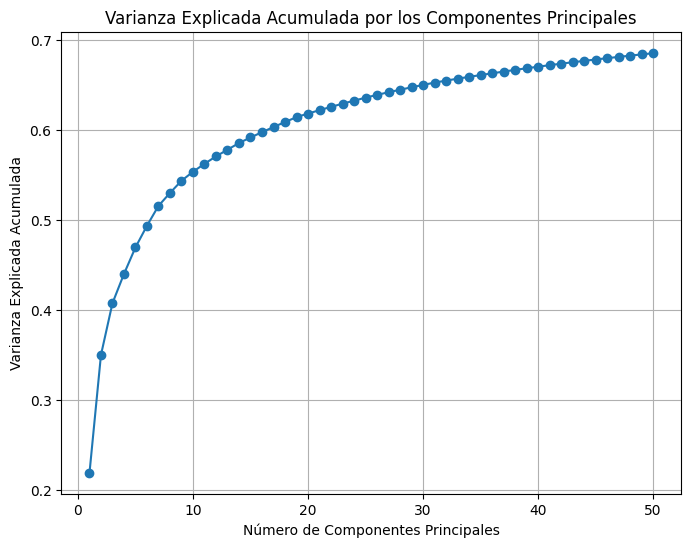

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Número de componentes que se desean mantener (por ejemplo, 50 componentes principales)
n_components = 50

# Aplicar PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_normalized)

# Ver las varianzas explicadas por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Graficar la varianza explicada acumulada por los componentes principales
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), np.cumsum(explained_variance_ratio), marker='o')
plt.title("Varianza Explicada Acumulada por los Componentes Principales")
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.grid(True)
plt.show()


In [ ]:
# Ver cuánta varianza explican los primeros componentes
cumulative_variance = np.cumsum(explained_variance_ratio)
print(f"Varianza explicada por los primeros {n_components} componentes: {cumulative_variance[-1]*100:.2f}%")


Varianza explicada por los primeros 50 componentes: 68.58%


In [ ]:
# Ver las cargas de los primeros componentes principales
componentes_principales = pca.components_

# Mostrar los primeros 3 componentes principales
for i in range(3):
    print(f"Componente {i+1}: {componentes_principales[i][:10]}")  # Muestra los primeros 10 valores de cada componente


Componente 1: [0.00794169 0.0092912  0.01118464 0.00802473 0.00941148 0.01133636
 0.00807717 0.00946423 0.01142121 0.00799148]
Componente 2: [-0.00950729 -0.00968404 -0.00847221 -0.00956923 -0.00977213 -0.00854898
 -0.00977906 -0.01000819 -0.00876696 -0.00972797]
Componente 3: [0.0125497  0.01020792 0.00528938 0.01271702 0.01036712 0.00535597
 0.01278808 0.01048156 0.00539322 0.01280538]


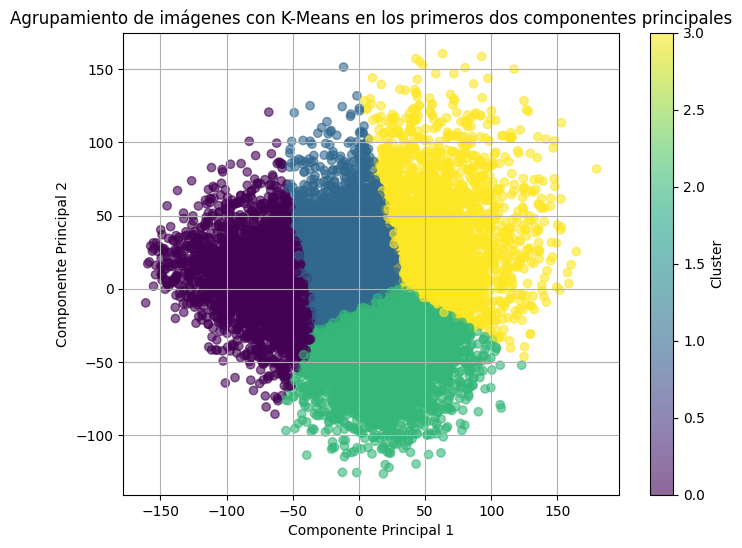

In [ ]:
from sklearn.cluster import KMeans

# Aplicar K-Means para agrupar las imágenes en clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualizar los clusters en los primeros dos componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Agrupamiento de imágenes con K-Means en los primeros dos componentes principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


4. Visualización e Interpretación:

### Visualización de los Componentes Principales
La visualización de los primeros dos o tres componentes principales nos ayudará a observar cómo se distribuyen las imágenes en el espacio de características reducido.

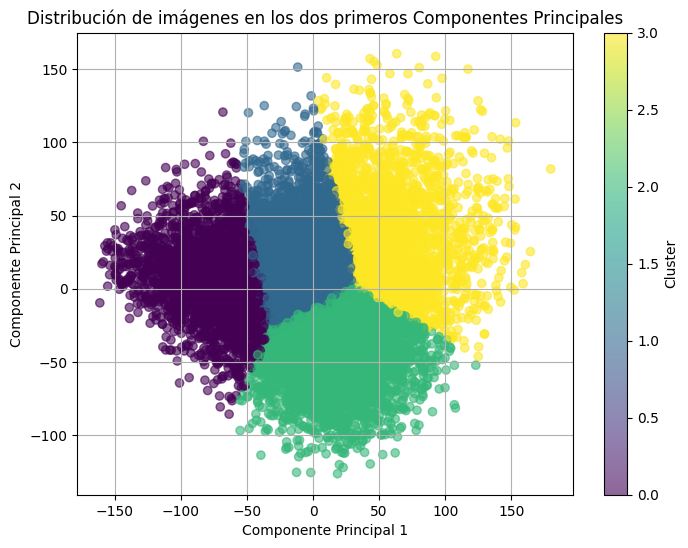

In [ ]:
# Visualizar las imágenes proyectadas sobre los dos primeros componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Distribución de imágenes en los dos primeros Componentes Principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Interpretación:

* Cada punto en la gráfica representa una imagen proyectada sobre los dos primeros componentes principales.
* Los colores representan los diferentes clusters generados por el algoritmo K-Means.
* Si las imágenes se agrupan de manera clara y coherente, es una indicación de que hay patrones que pueden ser utilizados en un modelo supervisado.

### Análisis de los Clusters
Examinemos los clusters obtenidos para ver si las imágenes dentro de cada grupo tienen características visuales similares.


Primeras imágenes del Cluster 0:


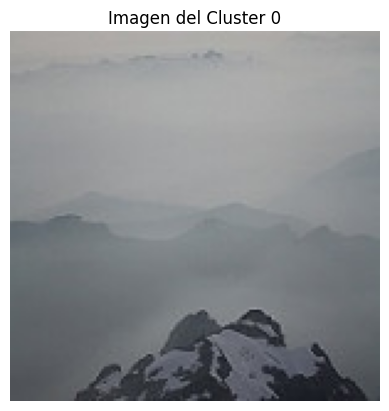

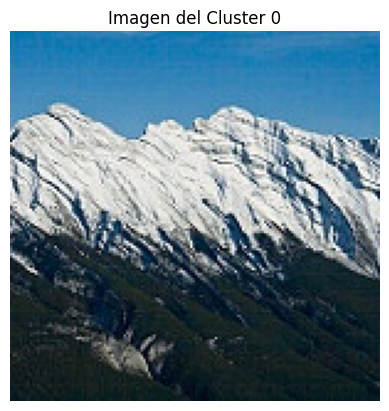

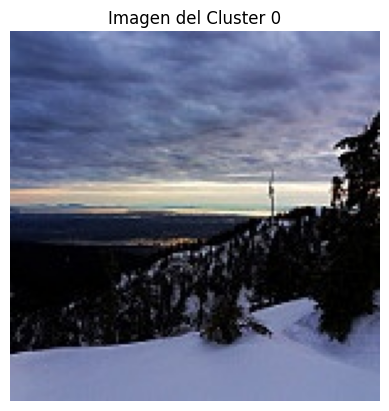

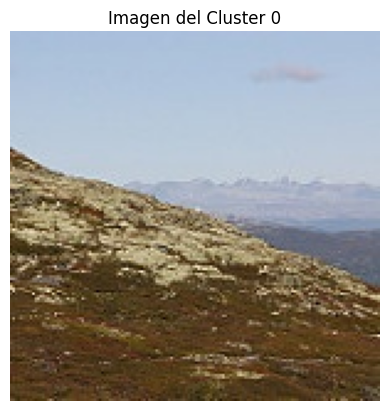

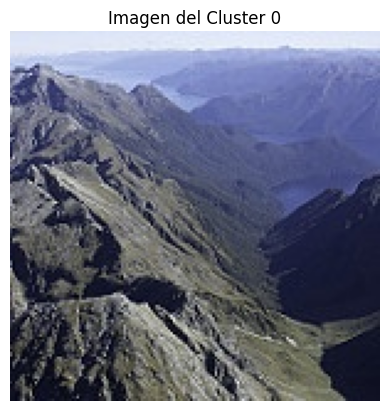


Primeras imágenes del Cluster 1:


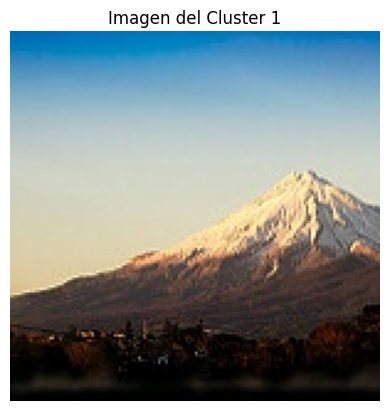

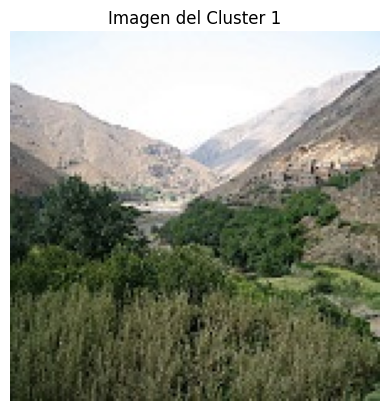

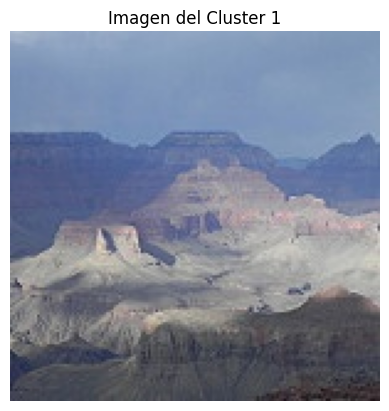

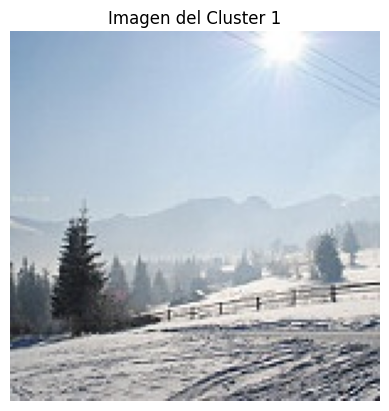

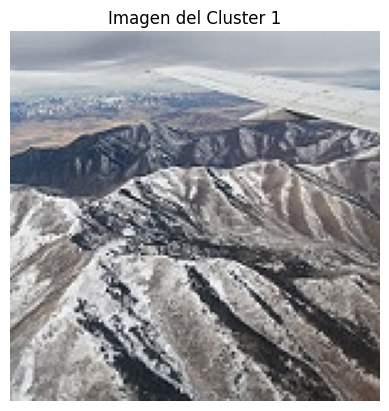


Primeras imágenes del Cluster 2:


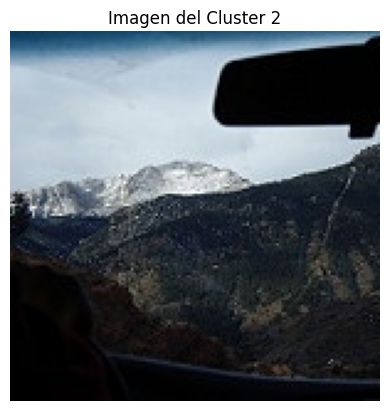

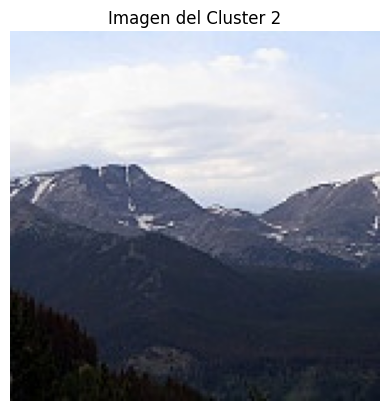

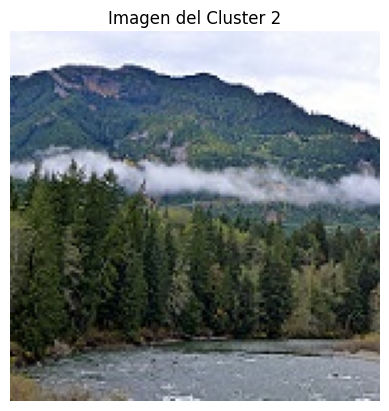

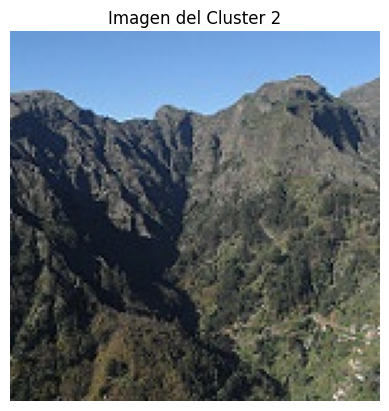

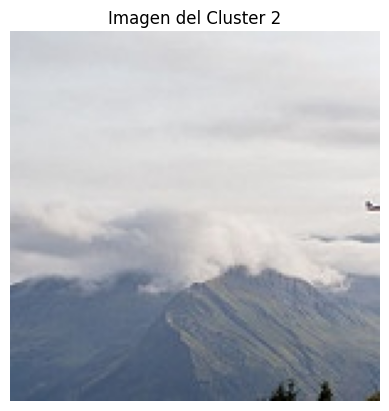


Primeras imágenes del Cluster 3:


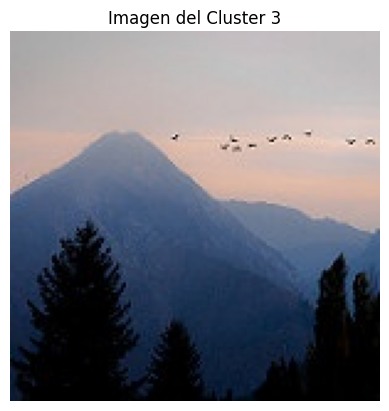

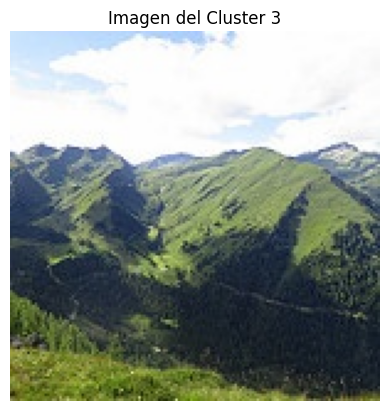

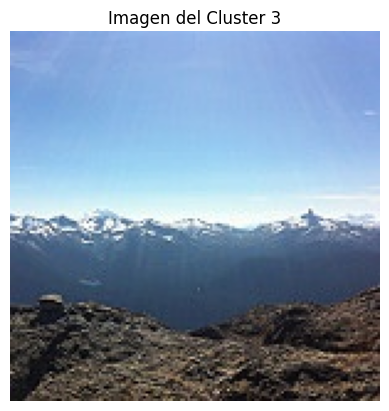

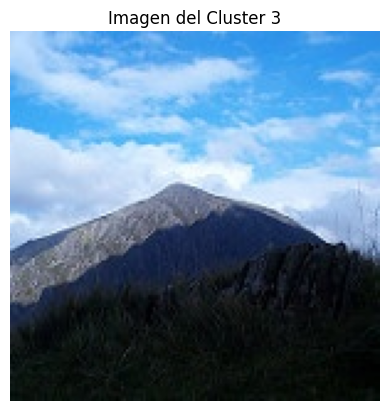

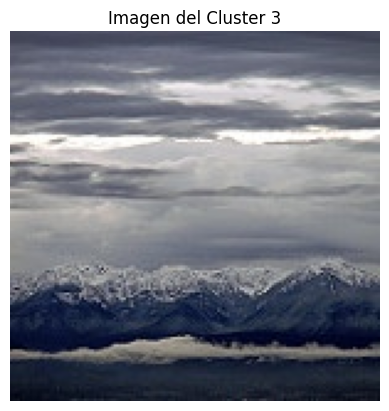

In [ ]:
# Ver las primeras imágenes de cada cluster
for cluster_num in range(4):  # Asumiendo que hay 4 clusters
    cluster_images = [img_file for idx, img_file in enumerate(image_files) if clusters[idx] == cluster_num]
    print(f"\nPrimeras imágenes del Cluster {cluster_num}:")
    for img_file in cluster_images[:5]:
        img_path = os.path.join(category_dir, img_file)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Imagen del Cluster {cluster_num}")
        plt.axis('off')
        plt.show()


Interpretación:

* Al visualizar las imágenes de cada cluster, podemos evaluar si hay una coherencia visual dentro de cada grupo.
* Si las imágenes en un mismo cluster representan, por ejemplo, terrenos similares (como desiertos o bosques), eso indica que los componentes principales están capturando diferencias significativas entre las categorías.

# Parte 2: Implementación de CNN

1. Arquitectura de la Red Convolucional:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Configuración de parámetros
IMG_SIZE = (128, 128)  # Tamaño al que se redimensionarán las imágenes
BATCH_SIZE = 32  # Número de imágenes por lote
EPOCHS = 10  # Número de iteraciones sobre el dataset
CLASSES = 6  # Número de categorías de terreno (bosque, desierto, montaña, etc.)

# Cargar imágenes con Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización
    validation_split=0.2,  # División en entrenamiento y validación
    horizontal_flip=True,  # Aumenta la diversidad de los datos
    rotation_range=10
)

train_generator = datagen.flow_from_directory(
    'data/seg_train/seg_train',  # Ruta de la carpeta con las imágenes
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'data/seg_train/seg_train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 11221 images belonging to 6 classes.
Found 2802 images belonging to 6 classes.


La CNN tendrá tres capas convolucionales, con MaxPooling para reducir dimensionalidad y una capa densa final con Softmax.

In [ ]:
# Definición de la arquitectura de la CNN
model = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Aplanar y agregar capas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Reduce overfitting
    Dense(CLASSES, activation='softmax')  # Capa de salida con softmax para clasificación multiclase
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen de la arquitectura
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo con los datos de entrenamiento y validación.

In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.4849 - loss: 1.2866 - val_accuracy: 0.6941 - val_loss: 0.8208
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.6710 - loss: 0.8900 - val_accuracy: 0.7602 - val_loss: 0.6662
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.7190 - loss: 0.7528 - val_accuracy: 0.7898 - val_loss: 0.6007
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7618 - loss: 0.6672 - val_accuracy: 0.7984 - val_loss: 0.5607
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7856 - loss: 0.6088 - val_accuracy: 0.8219 - val_loss: 0.5135
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.8019 - loss: 0.5656 - val_accuracy: 0.8258 - val_loss: 0.4900
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.8121 - loss: 0.5109 - val_accuracy: 0.8276 - val_loss: 0.5115
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.8193 - loss: 0.5181 - val_accu

Graficamos la precisión y la pérdida a lo largo de las épocas.

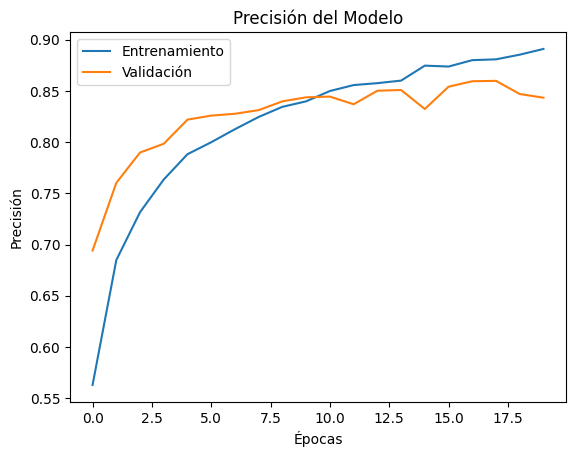

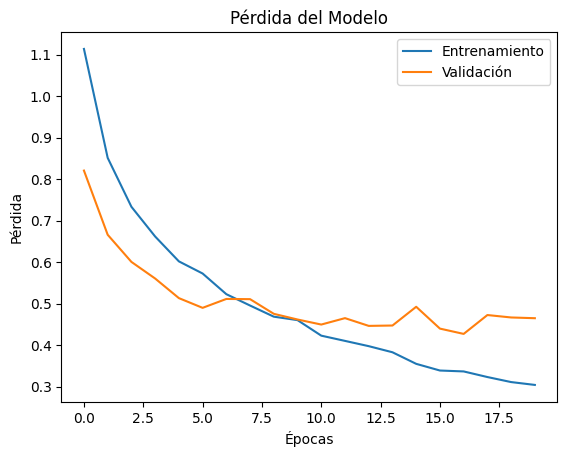

In [ ]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión del Modelo')
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida del Modelo')
plt.show()


Una vez entrenado, evaluamos el modelo y hacemos predicciones en imágenes nuevas.

In [ ]:
# Evaluación en el set de validación
loss, accuracy = model.evaluate(val_generator)
print(f"Precisión en validación: {accuracy:.2f}")


In [ ]:
# Cargar una imagen de prueba
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)

    print(f"La imagen pertenece a la categoría: {list(train_generator.class_indices.keys())[class_index]}")

# Prueba con una imagen externa
predict_image('data/seg_pred/seg_pred/')


2. Entrenamiento del Modelo:

El modelo se entrena usando los datos de entrenamiento y validación. Se usa Adam como optimizador y se mide la pérdida y la precisión en cada época.

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,  # Datos de entrenamiento
    epochs=EPOCHS,  # Número de épocas definido previamente
    validation_data=val_generator,  # Datos de validación
    verbose=1  # Mostrar información en cada época
)


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.9003 - loss: 0.2725 - val_accuracy: 0.8455 - val_loss: 0.5098
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.8944 - loss: 0.2892 - val_accuracy: 0.8515 - val_loss: 0.5040
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.8945 - loss: 0.2883 - val_accuracy: 0.8590 - val_loss: 0.4429
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.8977 - loss: 0.2691 - val_accuracy: 0.8508 - val_loss: 0.4828
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.9034 - loss: 0.2569 - val_accuracy: 0.8587 - val_loss: 0.4664
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.9065 - loss: 0.2650 - val_accuracy: 0.8519 - val_loss: 0.5289
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.9032 - loss: 0.2559 - val_accuracy: 0.8469 - val_loss: 0.4985
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9138 - loss: 0.2367 - val_accu

Después del entrenamiento, evaluamos el modelo con los datos de validación.

In [ ]:
# Evaluación del modelo en el conjunto de validación
loss, accuracy = model.evaluate(val_generator)
print(f"Precisión en validación: {accuracy:.2f}")
print(f"Pérdida en validación: {loss:.2f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step - accuracy: 0.8532 - loss: 0.7207
Precisión en validación: 0.85
Pérdida en validación: 0.67


Para evaluar el progreso del modelo, graficamos la precisión y la pérdida a lo largo de las épocas.

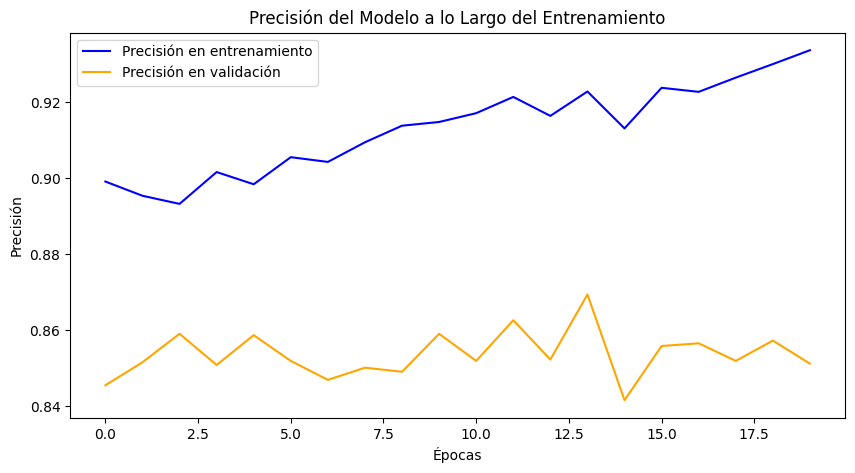

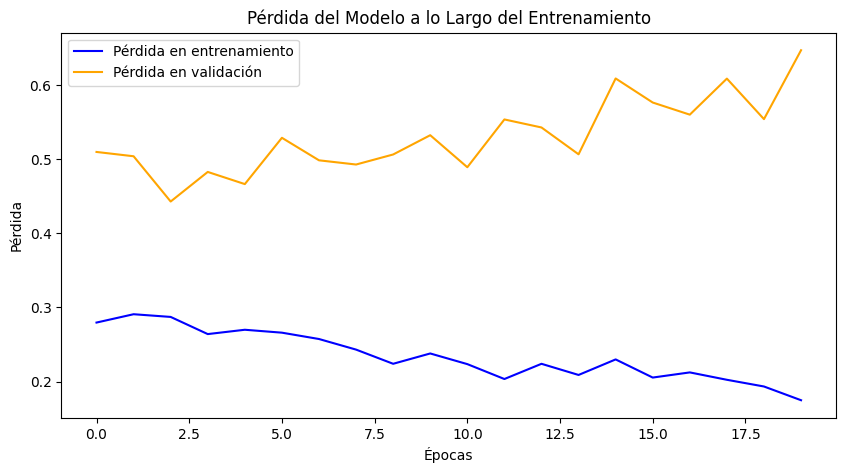

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de precisión (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento', color='blue')
plt.plot(history.history['val_accuracy'], label='Precisión en validación', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión del Modelo a lo Largo del Entrenamiento')
plt.show()

# Gráfica de pérdida (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Pérdida en validación', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida del Modelo a lo Largo del Entrenamiento')
plt.show()


3. Evaluación del Modelo:

Después del entrenamiento, evaluamos el rendimiento del modelo en los datos de prueba.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parámetros
IMG_SIZE = (224, 224)  # Ajusta según el tamaño de entrada de tu modelo
BATCH_SIZE = 32

# Crear un generador para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalización de imágenes

test_generator = test_datagen.flow_from_directory(
    'data/seg_test/',  # 📌 Asegúrate de que esta carpeta existe
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Ajusta según tu tipo de clasificación ('categorical', 'binary', etc.)
    shuffle=False  # No mezclar para mantener el orden correcto de las etiquetas
)

# Ahora, ya puedes usar test_generator en la evaluación
y_true = test_generator.classes  # Clases reales
y_pred_probs = model.predict(test_generator)  # Predicciones del modelo
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir a etiquetas

print("✅ Test generator definido correctamente. Puedes evaluar el modelo.")


FileNotFoundError: [Errno 2] No such file or directory: 'data/seg_test/'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas verdaderas y las predicciones del modelo
y_true = test_generator.classes  # Clases reales del conjunto de prueba
y_pred_probs = model.predict(test_generator)  # Predicciones del modelo (probabilidades)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertimos probabilidades a etiquetas

# Reporte de clasificación
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


NameError: name 'test_generator' is not defined

Para analizar los errores del modelo, graficamos la matriz de confusión.

In [ ]:
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()


NameError: name 'y_true' is not defined

4. Visualización de Resultados:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener imágenes del conjunto de prueba
X_test, y_true = next(test_generator)  # Tomamos un batch de imágenes y etiquetas reales
y_pred_probs = model.predict(X_test)  # Predicciones del modelo (probabilidades)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertimos probabilidades a etiquetas

# Seleccionar imágenes correctas e incorrectas
correct_indices = np.where(y_pred == y_true)[0]  # Índices de predicciones correctas
incorrect_indices = np.where(y_pred != y_true)[0]  # Índices de predicciones erróneas

# Mostrar imágenes correctamente clasificadas
plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:5]):  # Muestra 5 ejemplos correctos
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Correcto: {class_names[y_true[idx]]}\nPredicho: {class_names[y_pred[idx]]}")
    plt.axis("off")
plt.suptitle("Ejemplos Correctos")
plt.show()

# Mostrar imágenes mal clasificadas
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:5]):  # Muestra 5 ejemplos erróneos
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {class_names[y_true[idx]]}\nPredicho: {class_names[y_pred[idx]]}", color="red")
    plt.axis("off")
plt.suptitle("Ejemplos Mal Clasificados")
plt.show()


#Análisis de Errores y Posibles Mejoras
##Posibles motivos de errores:

* Terrenos visualmente similares: Montañas y bosques pueden compartir texturas y colores.
* Iluminación y ángulos diferentes: Si algunas imágenes están en sombras o tienen variaciones de ángulo, el modelo puede confundirse.
* Desbalance de clases: Si una categoría tiene más ejemplos que otra, el modelo puede estar sesgado.

##Mejoras posibles:

* Aumentar la cantidad de imágenes en clases menos representadas.
* Aplicar técnicas de data augmentation (rotaciones, cambios de brillo, etc.).
* Ajustar la arquitectura del modelo (más capas, dropout para evitar overfitting).